# **Dependancies**


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense
from tensorflow.keras import optimizers, losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import commons

# **Loading Data**


In [9]:
PATH_TO_DATA = "reg_interval1.csv"
data = pd.read_csv(PATH_TO_DATA)

In [10]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14
0,241.235663,-124.609037,2.364020,6695826.0,1.596,4.802511e+24,28.497,102.533,1880.0,111.703,95.902,101.342,106.790,42.924,0.1330
1,241.207190,-124.639809,2.214144,6695826.0,1.948,7.851852e+24,29.741,123.314,1557.0,119.740,101.303,108.257,110.343,81.728,0.1410
2,241.110210,-124.740878,1.885575,7673000.0,1.563,5.024273e+24,40.236,115.115,-3032.0,149.566,151.045,154.655,101.012,-13.192,0.1070
3,241.059700,-124.791761,1.545784,8974296.0,1.190,2.529764e+25,46.078,63.022,1882.0,108.586,92.513,97.039,99.145,-1.908,0.1100
4,241.076917,-124.768385,1.249267,8974296.0,0.745,4.897122e+25,46.657,73.620,1738.0,113.091,95.720,102.484,98.471,-1.425,0.0854


In [11]:
data.shape

(602, 15)

In [12]:
X = data.iloc[:,:-1]

In [13]:
y=data.iloc[:,-1:]

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [15]:
X_train.shape

(481, 14)

In [16]:
# # Prepare scalers
# estimators = [
#     ('robust', RobustScaler()),
#     ('minmax', MinMaxScaler())
# ]

In [17]:
# scaler=Pipeline(estimators,verbose=True)

In [18]:
# Prepare feature scalers
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

In [19]:
# Create a separate target scaler
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train)

### Reshape for GRU (samples, timesteps, features)


In [20]:
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# **Model Architecture + Training**


In [21]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [22]:
adam=optimizers.Adam(learning_rate=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


In [23]:
# Model Architecture
model = Sequential([
    Bidirectional(GRU(350, return_sequences=True, activation='relu'), 
                    input_shape=(1, X_train_reshaped.shape[2])),
    Bidirectional(GRU(350, activation='relu')),
    Dense(1)
])

g:\University\Term 3\Pattern Recognition\Presentation\Code\venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Compile model
model.compile(loss=losses.logcosh, optimizer=adam, metrics=['mae'])

In [25]:
# Callbacks
mcp_save = ModelCheckpoint('trained_models/GRU_reg_new.keras', 
                            save_best_only=True, 
                            monitor='val_loss', 
                            mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=100, 
                                verbose=1, 
                                mode='auto')

In [26]:
 # Train model
history = model.fit(
    X_train_reshaped, y_train, 
    epochs=5000, 
    batch_size=32, 
    validation_data=(X_test_reshaped, y_test), 
    callbacks=[mcp_save, early_stopping]
)

Epoch 1/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0022 - mae: 0.0475 - val_loss: 7.5181e-04 - val_mae: 0.0256
Epoch 2/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.9692e-04 - mae: 0.0166 - val_loss: 2.0056e-04 - val_mae: 0.0151
Epoch 3/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 1.5969e-04 - mae: 0.0107 - val_loss: 7.3381e-05 - val_mae: 0.0085
Epoch 4/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.9180e-04 - mae: 0.0113 - val_loss: 3.5583e-04 - val_mae: 0.0122
Epoch 5/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.5053e-05 - mae: 0.0076 - val_loss: 7.6823e-04 - val_mae: 0.0177
Epoch 6/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.4835e-04 - mae: 0.0114 - val_loss: 6.3911e-04 - val_mae: 0.0102
Epoch 7/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.0417e-04 - mae: 0.0086 - val_loss: 6.7592e-04 - val_mae: 0.0098
Epoch 8/5000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 7.1306e-05 - mae: 0.0076 - val_loss: 9.1682e-04 - val_

# **Testing Model**


In [31]:
# Load the trained model
prediction_model = load_model('trained_models/GRU_reg_new.keras', compile=False)

In [32]:
# Make predictions on scaled data
y_pred_scaled = prediction_model.predict(X_test_reshaped).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [33]:
# Inverse transform predictions and actual values
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = target_scaler.inverse_transform(y_test).flatten()

In [34]:
# Create comprehensive comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual Price': y_test_original,
    'Predicted Price': y_pred,
    'Absolute Error': np.abs(y_test_original - y_pred),
    'Percentage Error': np.abs(y_test_original - y_pred) / y_test_original * 100
})

In [35]:
# Calculate performance metrics
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mape = commons.mean_absolute_percentage_error(y_test_original, y_pred)

In [36]:
# Print results with more detailed formatting
print("Model Performance Metrics:")
metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 
               'Root Mean Square Error (RMSE)', 
               'Mean Absolute Percentage Error (MAPE)', 
               'R-squared (R²)'],
    'Value': [mae, rmse, mape, r2]
})
print(metrics_df.to_string(index=False))

Model Performance Metrics:
                               Metric    Value
            Mean Absolute Error (MAE) 0.005327
        Root Mean Square Error (RMSE) 0.007616
Mean Absolute Percentage Error (MAPE) 6.974751
                       R-squared (R²) 0.965771


In [37]:
# Print comprehensive comparison DataFrame
print("\nPrice Prediction Comparison:")
print(comparison_df)


Price Prediction Comparison:
     Actual Price  Predicted Price  Absolute Error  Percentage Error
0        0.066545         0.063811        0.002734          4.108219
1        0.066230         0.061946        0.004284          6.468598
2        0.068493         0.067222        0.001271          1.855177
3        0.052087         0.046542        0.005544         10.644442
4        0.051458         0.053577        0.002119          4.117998
..            ...              ...             ...               ...
116      0.089488         0.084204        0.005284          5.905103
117      0.075785         0.076876        0.001091          1.439981
118      0.077922         0.074611        0.003311          4.249699
119      0.082385         0.089831        0.007446          9.037629
120      0.051270         0.051842        0.000572          1.116421

[121 rows x 4 columns]


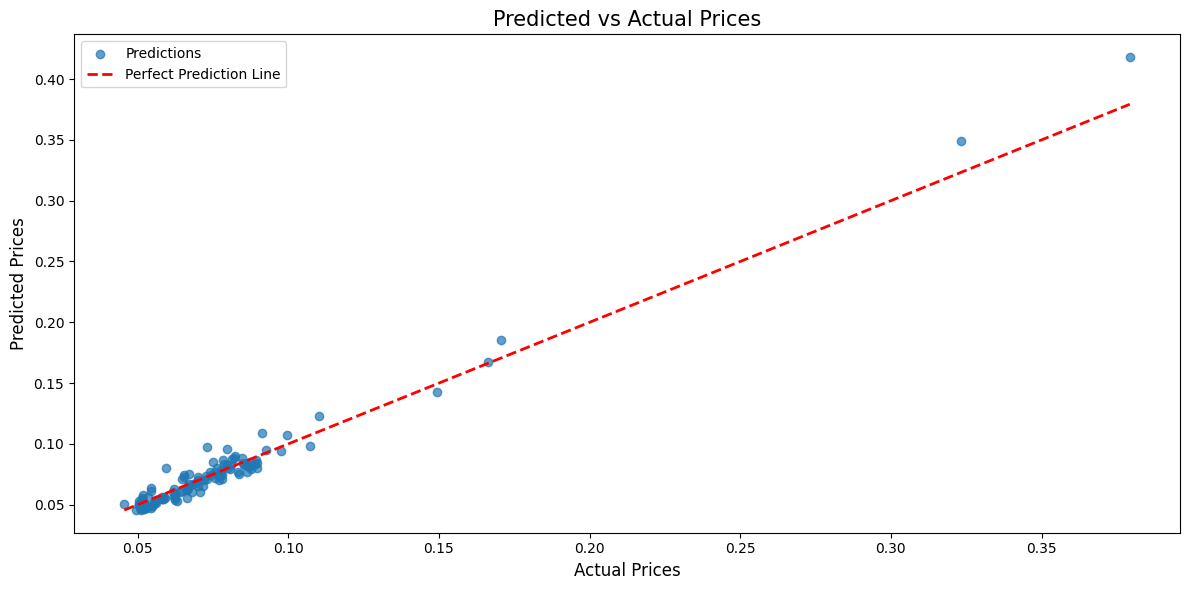

In [38]:
# Visualization of predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original, y_pred, alpha=0.7, label='Predictions')
plt.plot([y_test_original.min(), y_test_original.max()], 
         [y_test_original.min(), y_test_original.max()], 
         'r--', lw=2, label='Perfect Prediction Line')
plt.title('Predicted vs Actual Prices', fontsize=15)
plt.xlabel('Actual Prices', fontsize=12)
plt.ylabel('Predicted Prices', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [241]:
y_pred_scaled = model.predict(X_test_reshaped).flatten()
    
# Inverse transform predictions and actual values
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_original = target_scaler.inverse_transform(y_test).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [242]:
# Create comparison DataFrame with original prices
comparison_df = pd.DataFrame({
    'Actual Price': y_test_original,
    'Predicted Price': y_pred,
    'Absolute Error': np.abs(y_test_original - y_pred)
})

In [243]:
# Metrics (using original prices)
r2 = r2_score(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred))
mape = commons.mean_absolute_percentage_error(y_test_original, y_pred)

In [244]:
# Print and visualize results
print("Model Performance Metrics:")
metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R²'],
    'Value': [mae, rmse, mape, r2]
})
print(metrics_df)

Model Performance Metrics:
  Metric     Value
0    MAE  0.002576
1   RMSE  0.003901
2   MAPE  3.758281
3     R²  0.942121


In [245]:
# Print comparison DataFrame
print("\nPrice Prediction Comparison:")
print(comparison_df)


Price Prediction Comparison:
     Actual Price  Predicted Price  Absolute Error
0        0.046258         0.043378        0.002880
1        0.063845         0.059326        0.004519
2        0.061686         0.061996        0.000310
3        0.044988         0.044532        0.000456
4        0.045306         0.044870        0.000436
..            ...              ...             ...
116      0.083781         0.079106        0.004675
117      0.069940         0.070858        0.000919
118      0.072098         0.074759        0.002660
119      0.082765         0.090734        0.007969
120      0.043782         0.044627        0.000846

[121 rows x 3 columns]


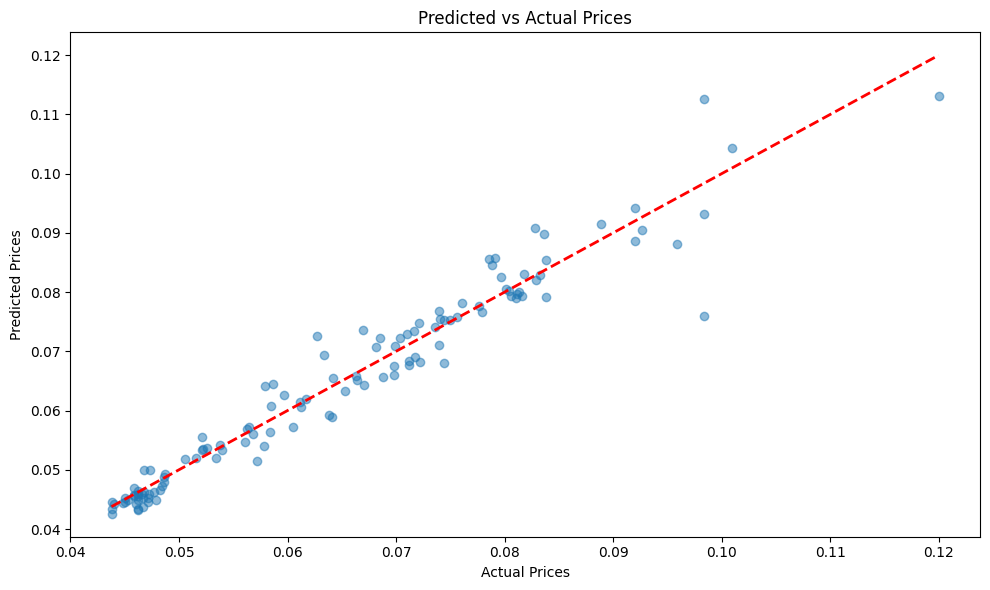

In [246]:
# Prediction vs Actual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()], 
            [y_test_original.min(), y_test_original.max()], 
            'r--', lw=2)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()

In [247]:
from tensorflow.keras.models import load_model
prediction_model = load_model('trained_models/GRU_reg_new.keras',compile=False)

In [248]:
y_pred = prediction_model.predict(X_test).flatten()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 14), dtype=float32). Expected shape (None, 1, 14), but input has incompatible shape (32, 14)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 14), dtype=float32)
  • training=False
  • mask=None

In [53]:
y_test=np.ravel(y_test)

In [54]:
r2=r2_score(y_test,y_pred) #testing score/ r^2
r2

0.9492389673647804

In [55]:
mae=mean_absolute_error(y_test,y_pred) #mae
mae

0.010646880552369703

In [56]:
rmse=np.sqrt(mean_squared_error(y_test,y_pred)) #rmse
rmse

np.float64(0.015085040026388077)

In [57]:
mape=mean_absolute_percentage_error(y_test,y_pred) #mape
mape

np.float64(14.734646159577968)

In [58]:
pd.DataFrame(zip(['MAE','RMSE','MAPE','R^2'],[mae,rmse,mape,r2])).transpose()

,0,1,2,3
0,MAE,RMSE,MAPE,R^2
1,0.010647,0.015085,14.734646,0.949239


In [59]:
pd.DataFrame([y_test,y_pred]).transpose()

,0,1
0,0.0334,0.031050
1,0.0526,0.052721
2,0.0626,0.055273
3,0.0338,0.040780
4,0.0306,0.025807
...,...,...
116,0.0909,0.068227
117,0.0749,0.067481
118,0.0771,0.065476
119,0.0827,0.094376
